# Phase 2.5: Advanced Sentiment Analysis

## 🎯 Advanced Features

This notebook extends Phase 2 with:

1. **Aspect-Based Sentiment Analysis (ABSA)**
   - Quality 🏆
   - Durability ⚒️
   - Installation 🔧
   - Design 🧩
   - Compatibility 🚘
   - Value for Money 💰

2. **Emotion Detection**
   - Happy 😊
   - Satisfied ✅
   - Disappointed 😞
   - Angry 😠
   - Neutral 😐

3. **Review Summarization**
   - Extract key strengths
   - Extract key weaknesses
   - Generate recommendation explanations

4. **Semantic Similarity**
   - TF-IDF based similarity for accessory matching
   - Content-based recommendation features

## 1. Setup & Import Libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import re
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📊 NumPy version: {np.__version__}")

✅ Libraries imported successfully!
📊 Pandas version: 2.3.3
📊 NumPy version: 2.3.4


## 2. Load Data with Sentiment Scores

In [2]:
# Define paths
processed_dir = Path('../../Dataset/processed')

# Load accessories with sentiment scores from Phase 2
print("📁 Loading accessories with sentiment scores...")
df = pd.read_csv(processed_dir / 'accessories_with_sentiment.csv')

print(f"✅ Loaded {len(df)} accessories")
print(f"\n📊 Dataset shape: {df.shape}")
print(f"\n📋 Columns: {df.columns.tolist()}")
print(f"\n📄 Sample data:")
df.head(3)

📁 Loading accessories with sentiment scores...
✅ Loaded 1739 accessories

📊 Dataset shape: (1739, 17)

📋 Columns: ['Accessory_ID', 'Car Brand', 'Car Model', 'Accessory Name', 'Accessory Price', 'Accessory Description', 'Compatible Cars', 'Top 5 Reviews', 'Brand_Normalized', 'Sentiment_VADER', 'Sentiment_Polarity', 'Sentiment_Subjectivity', 'Sentiment_Score', 'Sentiment_Label', 'Sentiment_Strength', 'Key_Phrases', 'Category']

📄 Sample data:


,Accessory_ID,Car Brand,Car Model,Accessory Name,Accessory Price,Accessory Description,Compatible Cars,Top 5 Reviews,Brand_Normalized,Sentiment_VADER,Sentiment_Polarity,Sentiment_Subjectivity,Sentiment_Score,Sentiment_Label,Sentiment_Strength,Key_Phrases,Category
0,1,Toyota,Land Cruiser Prado,100% Water Resistant Car Body Cover with Mirro...,375.2,"Heavy-duty car cover with triple stitching, mi...",Toyota Land Cruiser Prado,"Superb Quality Product: strong protection, wat...",toyota,0.9185,0.542424,0.596970,0.768070,Positive,Very Strong,"['good', 'best', 'quality']",Exterior
1,2,Citroen,eC3,10D Car Floor Mat Full Set,5999.0,"Custom Fitted Faux Leather Antiskid, 100% Wate...",Citroen eC3,High Quality & Great Value for Money!|hard kam...,citroen,0.8932,0.553333,0.696667,0.757253,Positive,Very Strong,"['great', 'best', 'quality', 'love']",Interior
2,3,Mahindra,XEV 9e,10D Car Foot Mat,6999.0,"Premium Leather, Luxurious, Waterproof, Custom...",Mahindra XEV 9E 2025 Onwards,Aditya Thakur: These mats are definitely value...,mahindra,0.9873,0.663636,0.763636,0.857835,Positive,Very Strong,"['excellent', 'great', 'good', 'perfect', 'qua...",Interior


## 3. Define Aspect Keywords & Emotion Keywords

In [3]:
# Define aspect-specific keywords (expanded and improved)
ASPECT_KEYWORDS = {
    'Quality': [
        'quality', 'material', 'premium', 'sturdy', 'solid', 'durable material',
        'build', 'construction', 'craftsmanship', 'finish', 'texture', 'fabric',
        'leather', 'heavy duty', 'thick', 'strong material', 'authentic'
    ],
    'Durability': [
        'durable', 'durability', 'lasting', 'long lasting', 'long term', 'wear',
        'tear', 'strong', 'robust', 'tough', 'reliable', 'withstand', 'holds up',
        'rugged', 'years', 'months', 'damage', 'break', 'broke', 'lasted'
    ],
    'Installation': [
        'install', 'installation', 'fit', 'fitting', 'easy to install', 'setup',
        'attach', 'mount', 'place', 'apply', 'assemble', 'assembly', 'instructions',
        'difficult', 'hard to install', 'complicated', 'simple', 'straightforward'
    ],
    'Design': [
        'design', 'look', 'looks', 'appearance', 'style', 'stylish', 'aesthetic',
        'beautiful', 'elegant', 'sleek', 'modern', 'attractive', 'pretty', 'ugly',
        'color', 'colours', 'pattern', 'finish', 'texture', 'visual'
    ],
    'Compatibility': [
        'fit', 'fits', 'fitting', 'compatible', 'compatibility', 'match', 'matches',
        'perfect fit', 'exact fit', 'custom fit', 'size', 'dimensions', 'model',
        'vehicle', 'car', "doesn't fit", 'wrong size', 'too big', 'too small'
    ],
    'Value': [
        'price', 'value', 'money', 'worth', 'expensive', 'cheap', 'affordable',
        'overpriced', 'reasonable', 'cost', 'budget', 'value for money', 'vfm',
        'good deal', 'great deal', 'waste of money', 'not worth'
    ],
    'Comfort': [
        'comfort', 'comfortable', 'soft', 'cushion', 'padding', 'support',
        'ergonomic', 'cozy', 'pleasant', 'uncomfortable', 'hard', 'rough'
    ],
    'Performance': [
        'performance', 'works', 'working', 'function', 'functional', 'effective',
        'efficiency', 'performs', 'does job', 'works well', 'not working',
        'failed', 'stopped working'
    ]
}

# Define emotion keywords
EMOTION_KEYWORDS = {
    'Happy': [
        'happy', 'love', 'loved', 'excellent', 'amazing', 'awesome', 'fantastic',
        'wonderful', 'great', 'superb', 'brilliant', 'perfect', 'delighted',
        'satisfied', 'pleased', 'thrilled', 'impressed'
    ],
    'Satisfied': [
        'good', 'nice', 'fine', 'okay', 'ok', 'decent', 'acceptable', 'satisfactory',
        'works', 'does job', 'as expected', 'meets expectations', 'fair'
    ],
    'Disappointed': [
        'disappointed', 'expected better', 'not good', 'below average', 'subpar',
        'mediocre', 'average', 'could be better', 'not impressed', 'letdown'
    ],
    'Angry': [
        'angry', 'terrible', 'horrible', 'worst', 'awful', 'pathetic', 'useless',
        'waste', 'garbage', 'junk', 'trash', 'disgusting', 'hate', 'frustrated',
        'furious', 'ridiculous'
    ],
    'Neutral': [
        'neutral', 'nothing special', 'average', 'normal', 'standard', 'regular',
        'basic', 'ordinary'
    ]
}

# Initialize VADER for aspect-level sentiment
vader = SentimentIntensityAnalyzer()

print("✅ Aspect keywords defined:")
for aspect, keywords in ASPECT_KEYWORDS.items():
    print(f"   {aspect}: {len(keywords)} keywords")

print("\n✅ Emotion keywords defined:")
for emotion, keywords in EMOTION_KEYWORDS.items():
    print(f"   {emotion}: {len(keywords)} keywords")

✅ Aspect keywords defined:
   Quality: 17 keywords
   Durability: 20 keywords
   Installation: 18 keywords
   Design: 20 keywords
   Compatibility: 19 keywords
   Value: 17 keywords
   Comfort: 12 keywords
   Performance: 13 keywords

✅ Emotion keywords defined:
   Happy: 17 keywords
   Satisfied: 13 keywords
   Disappointed: 10 keywords
   Angry: 16 keywords
   Neutral: 8 keywords


## 4. Aspect-Based Sentiment Analysis (ABSA)

In [4]:
def extract_aspect_sentiment(review_text):
    """
    Extract sentiment for each aspect from review text.
    Returns dictionary with aspect scores.
    """
    if pd.isna(review_text) or not isinstance(review_text, str):
        return {aspect: 0.0 for aspect in ASPECT_KEYWORDS.keys()}
    
    review_lower = review_text.lower()
    aspect_scores = {}
    
    for aspect, keywords in ASPECT_KEYWORDS.items():
        # Find sentences mentioning this aspect
        aspect_sentences = []
        sentences = sent_tokenize(review_text)
        
        for sentence in sentences:
            sentence_lower = sentence.lower()
            # Check if any keyword is in this sentence
            if any(keyword in sentence_lower for keyword in keywords):
                aspect_sentences.append(sentence)
        
        # Calculate sentiment for aspect-related sentences
        if aspect_sentences:
            aspect_text = ' '.join(aspect_sentences)
            sentiment = vader.polarity_scores(aspect_text)['compound']
            aspect_scores[aspect] = round(sentiment, 4)
        else:
            # No mention = neutral (0)
            aspect_scores[aspect] = 0.0
    
    return aspect_scores

def extract_aspect_mentions(review_text):
    """
    Count how many times each aspect is mentioned.
    """
    if pd.isna(review_text) or not isinstance(review_text, str):
        return {aspect: 0 for aspect in ASPECT_KEYWORDS.keys()}
    
    review_lower = review_text.lower()
    aspect_mentions = {}
    
    for aspect, keywords in ASPECT_KEYWORDS.items():
        count = sum(1 for keyword in keywords if keyword in review_lower)
        aspect_mentions[aspect] = count
    
    return aspect_mentions

print("🔍 Extracting aspect-based sentiments...")
print("This may take 1-2 minutes...\n")

# Extract aspect sentiments
aspect_sentiments = df['Top 5 Reviews'].apply(extract_aspect_sentiment)
aspect_mentions = df['Top 5 Reviews'].apply(extract_aspect_mentions)

# Convert to separate columns
for aspect in ASPECT_KEYWORDS.keys():
    df[f'Aspect_{aspect}_Score'] = aspect_sentiments.apply(lambda x: x[aspect])
    df[f'Aspect_{aspect}_Mentions'] = aspect_mentions.apply(lambda x: x[aspect])

print("✅ Aspect-based sentiment analysis complete!")
print(f"\n📊 Added {len(ASPECT_KEYWORDS) * 2} new columns (score + mentions for each aspect)")

# Show sample
aspect_columns = [col for col in df.columns if 'Aspect_' in col]
print(f"\n📄 Sample aspect scores:")
df[['Accessory Name'] + aspect_columns[:8]].head(3)

🔍 Extracting aspect-based sentiments...
This may take 1-2 minutes...

✅ Aspect-based sentiment analysis complete!

📊 Added 16 new columns (score + mentions for each aspect)

📄 Sample aspect scores:


,Accessory Name,Aspect_Quality_Score,Aspect_Quality_Mentions,Aspect_Durability_Score,Aspect_Durability_Mentions,Aspect_Installation_Score,Aspect_Installation_Mentions,Aspect_Design_Score,Aspect_Design_Mentions
0,100% Water Resistant Car Body Cover with Mirro...,0.7650,1,0.8834,1,0.9559,2,0.0000,0
1,10D Car Floor Mat Full Set,0.8932,1,0.0000,0,0.0000,0,0.0000,0
2,10D Car Foot Mat,0.9873,1,0.9577,1,0.9873,3,0.9873,3


## 5. Emotion Detection

In [5]:
def detect_emotions(review_text):
    """
    Detect emotions from review text.
    Returns dominant emotion and emotion scores.
    """
    if pd.isna(review_text) or not isinstance(review_text, str):
        return 'Neutral', {emotion: 0.0 for emotion in EMOTION_KEYWORDS.keys()}
    
    review_lower = review_text.lower()
    emotion_scores = {}
    
    for emotion, keywords in EMOTION_KEYWORDS.items():
        # Count keyword occurrences
        score = sum(review_lower.count(keyword) for keyword in keywords)
        emotion_scores[emotion] = score
    
    # Normalize scores
    total = sum(emotion_scores.values())
    if total > 0:
        emotion_scores = {k: round(v/total, 4) for k, v in emotion_scores.items()}
    else:
        emotion_scores = {k: 0.0 for k in emotion_scores}
    
    # Determine dominant emotion
    if total > 0:
        dominant_emotion = max(emotion_scores, key=emotion_scores.get)
    else:
        dominant_emotion = 'Neutral'
    
    return dominant_emotion, emotion_scores

print("😊 Detecting emotions in reviews...")

# Extract emotions
emotion_results = df['Top 5 Reviews'].apply(detect_emotions)

# Split into dominant emotion and scores
df['Dominant_Emotion'] = emotion_results.apply(lambda x: x[0])
for emotion in EMOTION_KEYWORDS.keys():
    df[f'Emotion_{emotion}_Score'] = emotion_results.apply(lambda x: x[1][emotion])

print("✅ Emotion detection complete!")
print(f"\n📊 Emotion distribution:")
print(df['Dominant_Emotion'].value_counts())

print(f"\n📄 Sample emotion scores:")
emotion_cols = ['Accessory Name', 'Dominant_Emotion'] + [f'Emotion_{e}_Score' for e in EMOTION_KEYWORDS.keys()]
df[emotion_cols].head(3)

😊 Detecting emotions in reviews...
✅ Emotion detection complete!

📊 Emotion distribution:
Dominant_Emotion
Satisfied       801
Happy           656
Neutral         267
Angry            11
Disappointed      4
Name: count, dtype: int64

📄 Sample emotion scores:


,Accessory Name,Dominant_Emotion,Emotion_Happy_Score,Emotion_Satisfied_Score,Emotion_Disappointed_Score,Emotion_Angry_Score,Emotion_Neutral_Score
0,100% Water Resistant Car Body Cover with Mirro...,Satisfied,0.2000,0.8000,0.0,0.0,0.0
1,10D Car Floor Mat Full Set,Happy,1.0000,0.0000,0.0,0.0,0.0
2,10D Car Foot Mat,Happy,0.7143,0.2857,0.0,0.0,0.0


## 6. Extract Key Strengths & Weaknesses

In [6]:
def extract_key_strengths(review_text, sentiment_score):
    """
    Extract key strengths from positive reviews.
    """
    if pd.isna(review_text) or not isinstance(review_text, str) or sentiment_score < 0.3:
        return "N/A"
    
    review_lower = review_text.lower()
    strengths = []
    
    # Check for quality mentions
    quality_words = ['excellent quality', 'great quality', 'high quality', 'premium quality', 
                     'superb quality', 'top quality', 'best quality']
    if any(word in review_lower for word in quality_words):
        strengths.append('High Quality')
    
    # Check for value mentions
    value_words = ['value for money', 'vfm', 'great value', 'worth', 'affordable', 'reasonable price']
    if any(word in review_lower for word in value_words):
        strengths.append('Great Value')
    
    # Check for fit mentions
    fit_words = ['perfect fit', 'exact fit', 'fits perfectly', 'great fit', 'custom fit']
    if any(word in review_lower for word in fit_words):
        strengths.append('Perfect Fit')
    
    # Check for durability
    durability_words = ['durable', 'long lasting', 'strong', 'robust', 'sturdy']
    if any(word in review_lower for word in durability_words):
        strengths.append('Durable')
    
    # Check for easy installation
    install_words = ['easy to install', 'easy installation', 'simple to install', 'quick install']
    if any(word in review_lower for word in install_words):
        strengths.append('Easy Installation')
    
    # Check for design
    design_words = ['beautiful', 'elegant', 'stylish', 'attractive', 'looks great', 'nice design']
    if any(word in review_lower for word in design_words):
        strengths.append('Great Design')
    
    return ', '.join(strengths) if strengths else 'Overall Positive'

def extract_key_weaknesses(review_text, sentiment_score):
    """
    Extract key weaknesses from negative reviews.
    """
    if pd.isna(review_text) or not isinstance(review_text, str) or sentiment_score > -0.3:
        return "N/A"
    
    review_lower = review_text.lower()
    weaknesses = []
    
    # Check for quality issues
    quality_issues = ['poor quality', 'bad quality', 'low quality', 'cheap quality', 'quality issue']
    if any(word in review_lower for word in quality_issues):
        weaknesses.append('Quality Issues')
    
    # Check for price concerns
    price_issues = ['overpriced', 'expensive', 'not worth', 'waste of money', 'too costly']
    if any(word in review_lower for word in price_issues):
        weaknesses.append('Overpriced')
    
    # Check for fit issues
    fit_issues = ["doesn't fit", "doesn't fit", 'wrong size', 'poor fit', 'not fitting', 'loose fit']
    if any(word in review_lower for word in fit_issues):
        weaknesses.append('Fit Issues')
    
    # Check for durability issues
    durability_issues = ['broke', 'broken', 'not durable', 'wear', 'tear', 'damaged']
    if any(word in review_lower for word in durability_issues):
        weaknesses.append('Durability Concerns')
    
    # Check for installation issues
    install_issues = ['hard to install', 'difficult installation', 'complicated', 'tough to install']
    if any(word in review_lower for word in install_issues):
        weaknesses.append('Installation Difficulty')
    
    return ', '.join(weaknesses) if weaknesses else 'Overall Negative'

print("💪 Extracting key strengths and weaknesses...")

df['Key_Strengths'] = df.apply(
    lambda row: extract_key_strengths(row['Top 5 Reviews'], row['Sentiment_Score']), 
    axis=1
)

df['Key_Weaknesses'] = df.apply(
    lambda row: extract_key_weaknesses(row['Top 5 Reviews'], row['Sentiment_Score']), 
    axis=1
)

print("✅ Key strengths and weaknesses extracted!")
print(f"\n📄 Sample:")
df[['Accessory Name', 'Sentiment_Score', 'Key_Strengths', 'Key_Weaknesses']].head(5)

💪 Extracting key strengths and weaknesses...
✅ Key strengths and weaknesses extracted!

📄 Sample:


,Accessory Name,Sentiment_Score,Key_Strengths,Key_Weaknesses
0,100% Water Resistant Car Body Cover with Mirro...,0.768070,"High Quality, Great Value, Durable",N/A
1,10D Car Floor Mat Full Set,0.757253,"High Quality, Great Value",N/A
2,10D Car Foot Mat,0.857835,"High Quality, Great Value, Perfect Fit",N/A
3,10D Car Foot Mat (Tan with Black),0.894831,"High Quality, Great Value, Perfect Fit",N/A
4,10D Premium Imported Car Floor Mat,0.751333,"High Quality, Great Value, Perfect Fit",N/A


## 7. Generate Recommendation Explanations

In [7]:
def generate_recommendation_explanation(row):
    """
    Generate human-readable explanation for why this accessory is recommended.
    This will be used in the frontend for explainable AI.
    """
    explanations = []
    
    # Overall sentiment
    sentiment_score = row['Sentiment_Score']
    sentiment_label = row['Sentiment_Label']
    
    if sentiment_score >= 0.7:
        explanations.append(f"⭐ Highly rated with {sentiment_score:.2f} sentiment score")
    elif sentiment_score >= 0.4:
        explanations.append(f"✅ Positively reviewed ({sentiment_score:.2f} sentiment)")
    
    # Aspect-based explanations
    aspect_scores = {
        'Quality': row['Aspect_Quality_Score'],
        'Durability': row['Aspect_Durability_Score'],
        'Installation': row['Aspect_Installation_Score'],
        'Design': row['Aspect_Design_Score'],
        'Value': row['Aspect_Value_Score']
    }
    
    # Find top 2 aspects
    top_aspects = sorted(aspect_scores.items(), key=lambda x: x[1], reverse=True)[:2]
    
    for aspect, score in top_aspects:
        if score >= 0.5:
            if aspect == 'Quality':
                explanations.append("🏆 Praised for high quality")
            elif aspect == 'Durability':
                explanations.append("⚒️ Known for durability")
            elif aspect == 'Installation':
                explanations.append("🔧 Easy to install")
            elif aspect == 'Design':
                explanations.append("🧩 Attractive design")
            elif aspect == 'Value':
                explanations.append("💰 Great value for money")
    
    # Category relevance
    category = row['Category']
    explanations.append(f"📁 {category} accessory")
    
    # Emotion
    emotion = row['Dominant_Emotion']
    if emotion == 'Happy':
        explanations.append("😊 Customers are very happy")
    elif emotion == 'Satisfied':
        explanations.append("✅ Customer satisfaction high")
    
    # Key strengths
    if row['Key_Strengths'] != 'N/A':
        strengths = row['Key_Strengths'].split(', ')[:2]  # Top 2 strengths
        for strength in strengths:
            explanations.append(f"✨ {strength}")
    
    return ' | '.join(explanations)

print("📝 Generating recommendation explanations...")

df['Recommendation_Explanation'] = df.apply(generate_recommendation_explanation, axis=1)

print("✅ Recommendation explanations generated!")
print(f"\n📄 Sample explanations:")
for idx, row in df.head(5).iterrows():
    print(f"\n{idx+1}. {row['Accessory Name'][:50]}...")
    print(f"   {row['Recommendation_Explanation']}")

📝 Generating recommendation explanations...
✅ Recommendation explanations generated!

📄 Sample explanations:

1. 100% Water Resistant Car Body Cover with Mirror (T...
   ⭐ Highly rated with 0.77 sentiment score | 🔧 Easy to install | ⚒️ Known for durability | 📁 Exterior accessory | ✅ Customer satisfaction high | ✨ High Quality | ✨ Great Value

2. 10D Car Floor Mat Full Set...
   ⭐ Highly rated with 0.76 sentiment score | 🏆 Praised for high quality | 💰 Great value for money | 📁 Interior accessory | 😊 Customers are very happy | ✨ High Quality | ✨ Great Value

3. 10D Car Foot Mat...
   ⭐ Highly rated with 0.86 sentiment score | 🏆 Praised for high quality | 🔧 Easy to install | 📁 Interior accessory | 😊 Customers are very happy | ✨ High Quality | ✨ Great Value

4. 10D Car Foot Mat (Tan with Black)...
   ⭐ Highly rated with 0.89 sentiment score | 🏆 Praised for high quality | 🔧 Easy to install | 📁 Interior accessory | 😊 Customers are very happy | ✨ High Quality | ✨ Great Value

5. 10D Premium I

## 8. Multi-Aspect Analysis Summary

In [8]:
print("📊 MULTI-ASPECT SENTIMENT ANALYSIS SUMMARY")
print("="*80)

print("\n1️⃣ ASPECT-BASED SENTIMENT SCORES (Average across all accessories)")
print("-" * 60)

aspect_score_cols = [col for col in df.columns if 'Aspect_' in col and '_Score' in col]
aspect_avg_scores = {}

for col in aspect_score_cols:
    aspect_name = col.replace('Aspect_', '').replace('_Score', '')
    avg_score = df[col].mean()
    mention_col = col.replace('_Score', '_Mentions')
    mention_count = (df[mention_col] > 0).sum()
    aspect_avg_scores[aspect_name] = avg_score
    print(f"   {aspect_name:15s}: {avg_score:6.3f} | Mentioned in {mention_count:4d} accessories ({mention_count/len(df)*100:.1f}%)")

# Find best and worst aspects
best_aspect = max(aspect_avg_scores, key=aspect_avg_scores.get)
worst_aspect = min(aspect_avg_scores, key=aspect_avg_scores.get)

print(f"\n   ✅ Best Aspect: {best_aspect} ({aspect_avg_scores[best_aspect]:.3f})")
print(f"   ⚠️  Worst Aspect: {worst_aspect} ({aspect_avg_scores[worst_aspect]:.3f})")

print("\n2️⃣ EMOTION DISTRIBUTION")
print("-" * 60)
emotion_dist = df['Dominant_Emotion'].value_counts()
for emotion, count in emotion_dist.items():
    print(f"   {emotion:15s}: {count:4d} ({count/len(df)*100:.1f}%)")

print("\n3️⃣ TOP 10 ACCESSORIES BY OVERALL QUALITY")
print("-" * 60)

# Calculate overall quality score
df['Overall_Quality_Score'] = (
    df['Sentiment_Score'] * 0.4 +
    df['Aspect_Quality_Score'] * 0.3 +
    df['Aspect_Durability_Score'] * 0.2 +
    df['Aspect_Value_Score'] * 0.1
)

top_quality = df.nlargest(10, 'Overall_Quality_Score')[[
    'Accessory Name', 'Car Brand', 'Overall_Quality_Score', 'Sentiment_Score',
    'Aspect_Quality_Score', 'Key_Strengths'
]]

for idx, row in top_quality.iterrows():
    print(f"   {row['Accessory Name'][:50]:50s} | {row['Car Brand']:15s} | Score: {row['Overall_Quality_Score']:.3f}")

print("\n" + "="*80)

📊 MULTI-ASPECT SENTIMENT ANALYSIS SUMMARY

1️⃣ ASPECT-BASED SENTIMENT SCORES (Average across all accessories)
------------------------------------------------------------
   Quality        :  0.387 | Mentioned in 1129 accessories (64.9%)
   Durability     :  0.069 | Mentioned in  273 accessories (15.7%)
   Installation   :  0.381 | Mentioned in 1005 accessories (57.8%)
   Design         :  0.181 | Mentioned in  470 accessories (27.0%)
   Compatibility  :  0.402 | Mentioned in 1120 accessories (64.4%)
   Value          :  0.251 | Mentioned in  712 accessories (40.9%)
   Comfort        :  0.041 | Mentioned in  128 accessories (7.4%)
   Performance    :  0.039 | Mentioned in  128 accessories (7.4%)

   ✅ Best Aspect: Compatibility (0.402)
   ⚠️  Worst Aspect: Performance (0.039)

2️⃣ EMOTION DISTRIBUTION
------------------------------------------------------------
   Satisfied      :  801 (46.1%)
   Happy          :  656 (37.7%)
   Neutral        :  267 (15.4%)
   Angry          :   11 (0

## 9. Visualizations


✅ Visualizations saved: ..\..\Dataset\processed\advanced_sentiment_visualizations.png


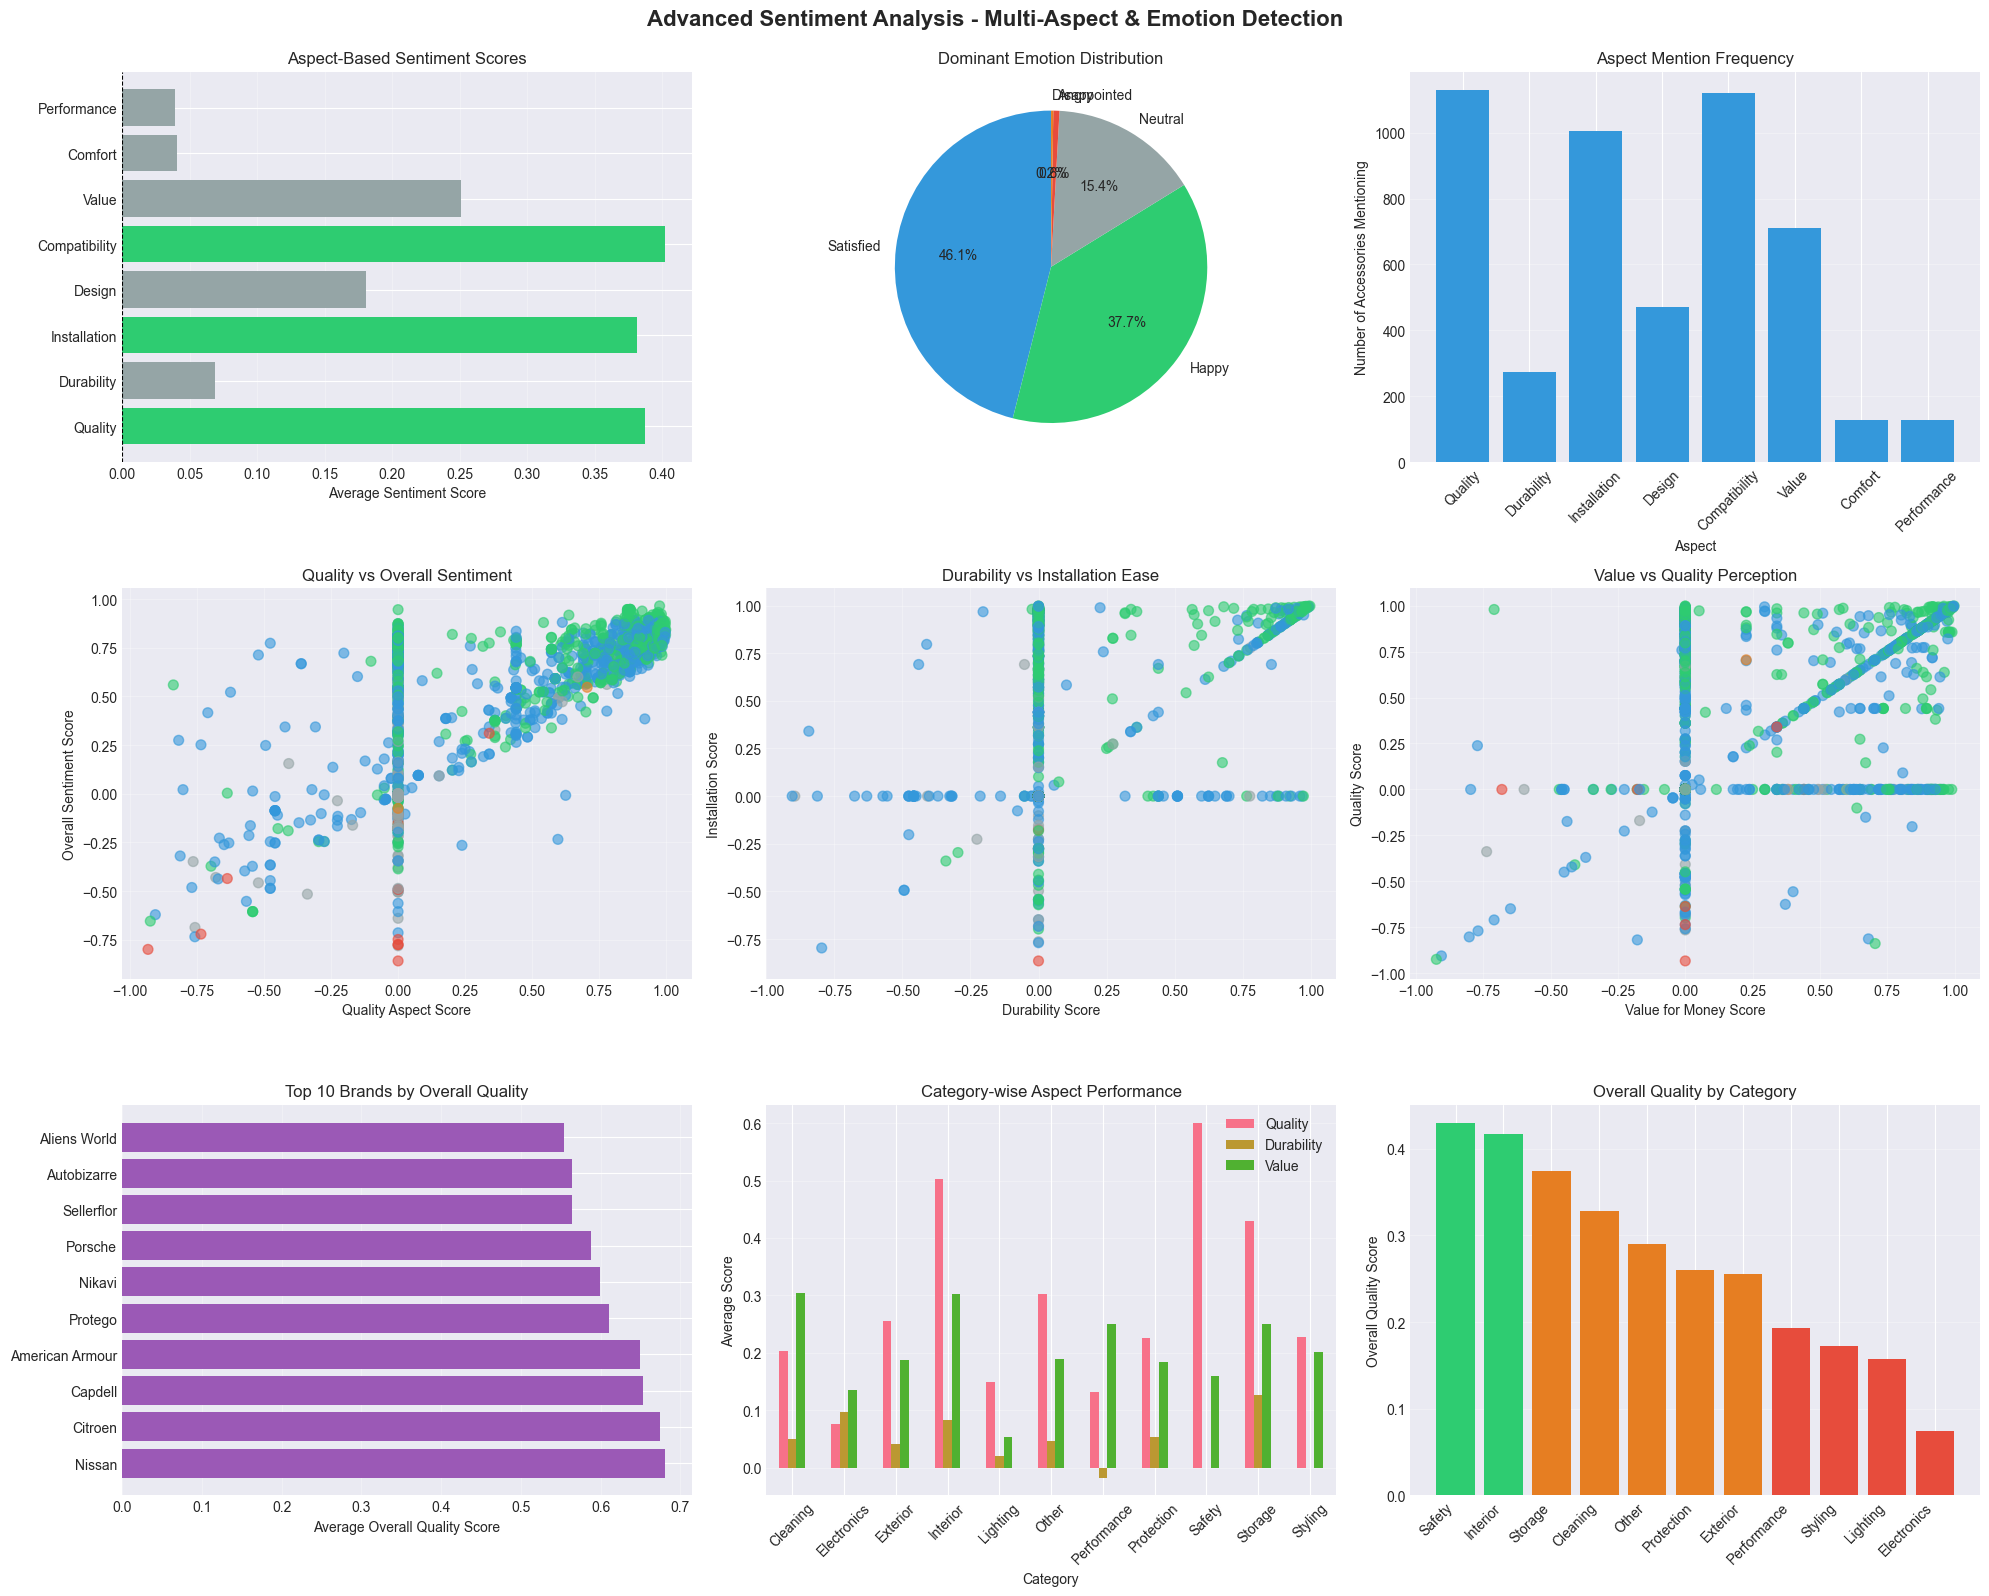

In [9]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
fig.suptitle('Advanced Sentiment Analysis - Multi-Aspect & Emotion Detection', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Aspect Sentiment Scores
ax1 = axes[0, 0]
aspect_names = list(aspect_avg_scores.keys())
aspect_values = list(aspect_avg_scores.values())
colors = ['#2ecc71' if v > 0.3 else '#e74c3c' if v < 0 else '#95a5a6' for v in aspect_values]
ax1.barh(aspect_names, aspect_values, color=colors)
ax1.set_xlabel('Average Sentiment Score')
ax1.set_title('Aspect-Based Sentiment Scores')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax1.grid(axis='x', alpha=0.3)

# 2. Emotion Distribution
ax2 = axes[0, 1]
emotion_counts = df['Dominant_Emotion'].value_counts()
emotion_colors = {'Happy': '#2ecc71', 'Satisfied': '#3498db', 'Neutral': '#95a5a6', 
                  'Disappointed': '#e67e22', 'Angry': '#e74c3c'}
colors = [emotion_colors.get(e, '#95a5a6') for e in emotion_counts.index]
ax2.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Dominant Emotion Distribution')

# 3. Aspect Mention Frequency
ax3 = axes[0, 2]
mention_cols = [col for col in df.columns if 'Aspect_' in col and '_Mentions' in col]
mention_counts = {}
for col in mention_cols:
    aspect = col.replace('Aspect_', '').replace('_Mentions', '')
    mention_counts[aspect] = (df[col] > 0).sum()
aspect_names = list(mention_counts.keys())
mention_values = list(mention_counts.values())
ax3.bar(aspect_names, mention_values, color='#3498db')
ax3.set_xlabel('Aspect')
ax3.set_ylabel('Number of Accessories Mentioning')
ax3.set_title('Aspect Mention Frequency')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 4. Quality vs Sentiment Scatter
ax4 = axes[1, 0]
scatter_colors = df['Dominant_Emotion'].map(emotion_colors)
ax4.scatter(df['Aspect_Quality_Score'], df['Sentiment_Score'], 
            c=scatter_colors, alpha=0.6, s=50)
ax4.set_xlabel('Quality Aspect Score')
ax4.set_ylabel('Overall Sentiment Score')
ax4.set_title('Quality vs Overall Sentiment')
ax4.grid(True, alpha=0.3)

# 5. Durability vs Installation
ax5 = axes[1, 1]
ax5.scatter(df['Aspect_Durability_Score'], df['Aspect_Installation_Score'],
            c=scatter_colors, alpha=0.6, s=50)
ax5.set_xlabel('Durability Score')
ax5.set_ylabel('Installation Score')
ax5.set_title('Durability vs Installation Ease')
ax5.grid(True, alpha=0.3)

# 6. Value vs Quality
ax6 = axes[1, 2]
ax6.scatter(df['Aspect_Value_Score'], df['Aspect_Quality_Score'],
            c=scatter_colors, alpha=0.6, s=50)
ax6.set_xlabel('Value for Money Score')
ax6.set_ylabel('Quality Score')
ax6.set_title('Value vs Quality Perception')
ax6.grid(True, alpha=0.3)

# 7. Top 10 Brands by Overall Quality
ax7 = axes[2, 0]
brand_quality = df.groupby('Car Brand')['Overall_Quality_Score'].mean().nlargest(10)
ax7.barh(brand_quality.index, brand_quality.values, color='#9b59b6')
ax7.set_xlabel('Average Overall Quality Score')
ax7.set_title('Top 10 Brands by Overall Quality')
ax7.grid(axis='x', alpha=0.3)

# 8. Category-wise Aspect Performance
ax8 = axes[2, 1]
category_aspects = df.groupby('Category')[['Aspect_Quality_Score', 'Aspect_Durability_Score', 
                                             'Aspect_Value_Score']].mean()
category_aspects.plot(kind='bar', ax=ax8, rot=45)
ax8.set_xlabel('Category')
ax8.set_ylabel('Average Score')
ax8.set_title('Category-wise Aspect Performance')
ax8.legend(['Quality', 'Durability', 'Value'], loc='upper right')
ax8.grid(axis='y', alpha=0.3)

# 9. Sentiment Distribution by Category
ax9 = axes[2, 2]
category_sentiment = df.groupby('Category')['Overall_Quality_Score'].mean().sort_values(ascending=False)
colors = ['#2ecc71' if v > 0.4 else '#e67e22' if v > 0.2 else '#e74c3c' for v in category_sentiment.values]
ax9.bar(range(len(category_sentiment)), category_sentiment.values, color=colors)
ax9.set_xticks(range(len(category_sentiment)))
ax9.set_xticklabels(category_sentiment.index, rotation=45, ha='right')
ax9.set_ylabel('Overall Quality Score')
ax9.set_title('Overall Quality by Category')
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save visualization
viz_file = processed_dir / 'advanced_sentiment_visualizations.png'
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
print(f"\n✅ Visualizations saved: {viz_file}")

plt.show()

## 10. Save Enhanced Dataset

In [10]:
print("💾 SAVING ENHANCED DATASET")
print("="*80)

# Save to CSV
output_file = processed_dir / 'accessories_with_advanced_sentiment.csv'
df.to_csv(output_file, index=False)

print(f"\n✅ Saved: {output_file}")
print(f"   - {len(df)} rows")
print(f"   - {len(df.columns)} columns")

print("\n📊 NEW COLUMNS ADDED:")
new_columns = [
    '# Aspect-based sentiment scores (8 aspects × 2 = 16 columns)',
    '  - Aspect_Quality_Score, Aspect_Quality_Mentions',
    '  - Aspect_Durability_Score, Aspect_Durability_Mentions',
    '  - Aspect_Installation_Score, Aspect_Installation_Mentions',
    '  - Aspect_Design_Score, Aspect_Design_Mentions',
    '  - Aspect_Compatibility_Score, Aspect_Compatibility_Mentions',
    '  - Aspect_Value_Score, Aspect_Value_Mentions',
    '  - Aspect_Comfort_Score, Aspect_Comfort_Mentions',
    '  - Aspect_Performance_Score, Aspect_Performance_Mentions',
    '',
    '# Emotion detection (6 columns)',
    '  - Dominant_Emotion',
    '  - Emotion_Happy_Score, Emotion_Satisfied_Score, Emotion_Disappointed_Score',
    '  - Emotion_Angry_Score, Emotion_Neutral_Score',
    '',
    '# Explainable features (4 columns)',
    '  - Key_Strengths',
    '  - Key_Weaknesses',
    '  - Recommendation_Explanation',
    '  - Overall_Quality_Score',
]
for col in new_columns:
    print(col)

print(f"\n📈 TOTAL NEW FEATURES: ~26 columns")
print(f"📈 TOTAL DATASET SIZE: {len(df.columns)} columns")

print("\n" + "="*80)
print("✅ PHASE 2.5 COMPLETE - ADVANCED SENTIMENT ANALYSIS SUCCESSFUL!")
print("="*80)

print("\n📝 Next Steps:")
print("   1. Use aspect scores for personalized filtering")
print("   2. Use emotion scores for emotion-aware recommendations")
print("   3. Use explanation text in frontend for transparency")
print("   4. Use Overall_Quality_Score for ranking")
print("\n🚀 Ready for Phase 3: Recommendation Engine with Explainable AI!")

💾 SAVING ENHANCED DATASET

✅ Saved: ..\..\Dataset\processed\accessories_with_advanced_sentiment.csv
   - 1739 rows
   - 43 columns

📊 NEW COLUMNS ADDED:
# Aspect-based sentiment scores (8 aspects × 2 = 16 columns)
  - Aspect_Quality_Score, Aspect_Quality_Mentions
  - Aspect_Durability_Score, Aspect_Durability_Mentions
  - Aspect_Installation_Score, Aspect_Installation_Mentions
  - Aspect_Design_Score, Aspect_Design_Mentions
  - Aspect_Compatibility_Score, Aspect_Compatibility_Mentions
  - Aspect_Value_Score, Aspect_Value_Mentions
  - Aspect_Comfort_Score, Aspect_Comfort_Mentions
  - Aspect_Performance_Score, Aspect_Performance_Mentions

# Emotion detection (6 columns)
  - Dominant_Emotion
  - Emotion_Happy_Score, Emotion_Satisfied_Score, Emotion_Disappointed_Score
  - Emotion_Angry_Score, Emotion_Neutral_Score

# Explainable features (4 columns)
  - Key_Strengths
  - Key_Weaknesses
  - Recommendation_Explanation
  - Overall_Quality_Score

📈 TOTAL NEW FEATURES: ~26 columns
📈 TOTAL DATAS